# 1. 读取mnist 数据

In [87]:
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer
import torch
import torchvision
from torch.utils.data import DataLoader
import numpy as np
from sklearn.model_selection import train_test_split

train = torchvision.datasets.MNIST("../data/", train=True, download=True)
test = torchvision.datasets.MNIST("../data/", train=False, download=True)
train_data, train_labels = train.data.numpy(), train.targets.numpy()
test_data, test_labels = test.data.numpy(), test.targets.numpy()
train_data = train_data.reshape((-1, 28 * 28))
test_data = test_data.reshape((-1, 28 * 28))
train_length = train_data.shape[0]
data = np.concatenate((train_data, test_data), axis=0)
data = MinMaxScaler().fit_transform(data)
train_data = data[0:train_length, ]
test_data = data[train_length:, ]
train_labels = np.expand_dims(train_labels, axis=1)
test_labels = np.expand_dims(test_labels, axis=1)
train_labels = MultiLabelBinarizer().fit_transform(train_labels)
test_labels = MultiLabelBinarizer().fit_transform(test_labels)
train_data, val_data, train_labels, valid_labels = train_test_split(train_data, train_labels, test_size=0.1,
                                                                    shuffle=True, random_state=42)

step:0: loss=1.803680658340454, acc=47.400001525878906%
step:200: loss=0.37734371423721313, acc=88.83332824707031%
step:400: loss=0.35747990012168884, acc=89.66666412353516%
step:600: loss=0.3504292666912079, acc=90.43333435058594%
step:800: loss=0.3325308859348297, acc=90.33332824707031%
epoch 0: train_loss: 0.644293, test_loss: 0.313694, train_acc=81.333333%, test_acc=90.849998%
step:0: loss=0.3141980469226837, acc=90.75%
step:200: loss=0.32102131843566895, acc=90.68333435058594%
step:400: loss=0.32100558280944824, acc=90.68333435058594%
step:600: loss=0.30207762122154236, acc=91.39999389648438%
step:800: loss=0.3054523169994354, acc=91.03333282470703%
epoch 1: train_loss: 0.312751, test_loss: 0.308788, train_acc=90.909994%, test_acc=91.209999%
step:0: loss=0.31174764037132263, acc=91.04999542236328%
step:200: loss=0.2924950420856476, acc=92.13333129882812%
step:400: loss=0.2989234924316406, acc=91.53333282470703%
step:600: loss=0.3245158791542053, acc=90.86666870117188%
step:800: lo

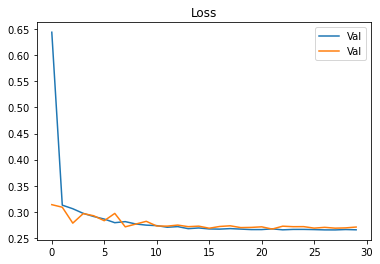

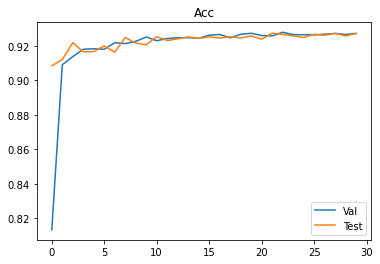

In [88]:
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset
from torch.optim import Adam, lr_scheduler
from torch.nn import Sequential
import torch.nn as nn

batch_size = 64
max_epoch = 30
train = TensorDataset(torch.FloatTensor(train_data), torch.FloatTensor(train_labels))

dataloader = DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
test_data = torch.FloatTensor(test_data).cuda()
test_target = torch.FloatTensor(test_labels).cuda()
val_data = torch.FloatTensor(val_data).cuda()
valid_labels = torch.FloatTensor(valid_labels).cuda()


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = Sequential(
            nn.Linear(784, 128, bias=True),
            nn.BatchNorm1d(128),  #RELU 不行，换这个里面就上去了
            nn.Linear(128, 64, bias=True),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32, bias=True),
            nn.BatchNorm1d(32),
            nn.Linear(32, 16, bias=True),
            nn.BatchNorm1d(16),
            nn.Linear(16, 10, bias=True),
            #nn.Softmax(dim=1)  #CrossEntropyLoss 已经有了，加上正确率只有91.87
        )

    def forward(self, x):
        return self.model(x)


lr = 0.01
model = Model()
model.cuda()
loss_func = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
train_loss = []
train_acc = []
test_loss = []
test_acc = []
for epoch in range(max_epoch):
    epoch_loss = []
    epoch_acc = []
    for step, (batch_x, batch_y) in enumerate(dataloader):
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        pred = model(batch_x)
        loss = loss_func(pred, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step % 200 == 0:
            pred = model(val_data)
            loss = loss_func(pred, valid_labels)
            acc = torch.eq(pred.argmax(1), valid_labels.argmax(1)).sum() / len(valid_labels)
            epoch_acc.append(acc.cpu().data)
            epoch_loss.append(loss.cpu().data)
            print(f"step:{step}: loss={loss.cpu().data}, acc={acc * 100}%")
    scheduler.step()
    train_loss.append(np.mean(epoch_loss))
    train_acc.append(np.mean(epoch_acc))
    pred = model(test_data)
    loss = loss_func(pred, test_target)
    acc = torch.eq(pred.argmax(1), test_target.argmax(1)).sum() / len(test_target)
    test_loss.append(loss.cpu().data)
    test_acc.append(acc.cpu().data)
    print(
        f"\033[0;35mepoch {epoch}: train_loss: {np.mean(epoch_loss):.6f}, test_loss: {loss.cpu().data:.6f}, train_acc={np.mean(epoch_acc) * 100:.6f}%, test_acc={acc * 100:.6f}%\033[0m")

plt.plot([i for i in range(max_epoch)], train_loss)  # training loss
plt.plot([i for i in range(max_epoch)], test_loss)  # validate loss
plt.title("Loss")
plt.legend(["Val", "Val"])
plt.show()

plt.plot([i for i in range(max_epoch)], train_acc)  # training loss
plt.plot([i for i in range(max_epoch)], test_acc)  # validate loss
plt.title("Acc")
plt.legend(["Val", "Test"])
plt.show()
